<a href="https://colab.research.google.com/github/ansariwaleed/GNN-implementations/blob/main/Bayesian_Structure_Learning_Algorithm_for_EEG_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##step 1: importing necessary libraries and load the EEG data

In [1]:
!pip install mne
!pip install networkx

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import mne
import os
from pathlib import Path
import pandas as pd
from scipy import stats
from tqdm import tqdm  # for progress bars
import warnings
import matplotlib.image as mpimg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.8 MB/s eta 0:00:00


##step 2: Load and preprocess the EEG

In [2]:
data_path = '/content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0'

#lsit available EDF files
edf_files = []
for root,dirs,files in os.walk(data_path):
  for file in files:
    if file.endswith('.edf'):
      edf_files.append(os.path.join(root,file))

print(f"Found {len(edf_files)} EDF files")

Found 72 EDF files


In [3]:
#load the first EDF file for the demonstration
if edf_files:
    raw = mne.io.read_raw_edf('/content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_2.edf', preload=True)
    print(f"Loaded file: {edf_files[0]}")

    # Display information about the data
    print("\nEEG Data Information:")
    print(f"Number of channels: {len(raw.ch_names)}")
    print(f"Channel names: {raw.ch_names}")
    print(f"Sampling frequency: {raw.info['sfreq']} Hz")
    print(f"Duration: {raw.times.max():.2f} seconds")


    # Convert to numpy array for processing
    eeg_data = raw.get_data()
    print(f"Data shape: {eeg_data.shape}")  # (N, T) where N is channels and T is time points
else:
    print("No EDF files found. Please check the data path.")

Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Loaded file: /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_1.edf

EEG Data Information:
Number of channels: 21
Channel names: ['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6', 'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG A2-A1', 'ECG ECG']
Sampling frequency: 500.0 Hz
Duration: 62.00 seconds
Data shape: (21, 31000)


## step 3 : Initializing graph structure

In [4]:
# Step 3: Initialize the graph structure G
def is_weakly_connected(adjacency_matrix):
    """Check if the graph represented by the adjacency matrix is weakly connected"""
    G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph())
    return nx.is_weakly_connected(G)

# Extract number of channels (nodes)
N = len(raw.ch_names)

# Initialize graph structure as a fully connected graph
# (alternatively, you could start with an empty graph or any other initialization)
G_initial = np.ones((N, N)) - np.eye(N)  # Fully connected except self-loops

# Alternatively, initialize as a random graph with some probability of edge existence
# edge_probability = 0.3
# G_initial = np.random.rand(N, N) < edge_probability
# np.fill_diagonal(G_initial, 0)  # No self-loops

# Ensure the graph is weakly connected
if not is_weakly_connected(G_initial):
    print("Initial graph is not weakly connected. Adding edges to connect it.")
    # Create a connected graph if not already connected
    for i in range(N-1):
        G_initial[i, i+1] = 1
        G_initial[i+1, i] = 1

print(f"Initial graph is weakly connected: {is_weakly_connected(G_initial)}")
print(f"Graph shape: {G_initial.shape}")

# Visualize the initial graph
plt.figure(figsize=(10, 8))
G = nx.from_numpy_array(G_initial, create_using=nx.DiGraph())
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=500,
        node_color='lightblue', font_weight='bold')
plt.title("Initial Graph Structure")
plt.savefig("initial_graph.png")
plt.close()

Initial graph is weakly connected: True
Graph shape: (21, 21)


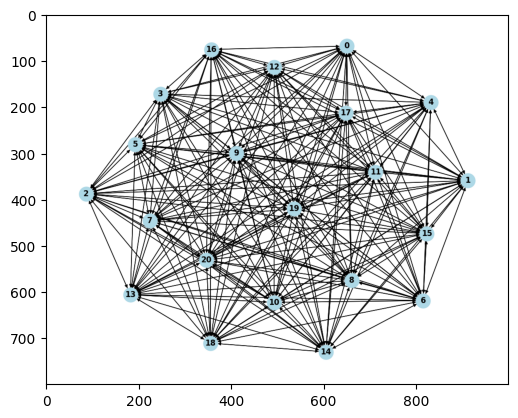

In [5]:
img = mpimg.imread('initial_graph.png')
imgplot = plt.imshow(img)
plt.show()


## step 4: Implementing the Bayesian Score

In [6]:
def calculate_bayesian_score(data, graph):
    """
    Calculate the Bayesian score for a directed graph given the data.
    Using the Bayesian Dirichlet equivalent (BDe) score.

    Parameters:
    data: numpy array of shape (N, T) where N is the number of nodes and T is the number of time points
    graph: adjacency matrix of shape (N, N)

    Returns:
    score: The Bayesian score
    """
    N, T = data.shape

    # Initialize the score
    total_score = 0

    # For each node
    for i in range(N):
        # Get the parents of node i
        parents = np.where(graph[:, i] == 1)[0]

        if len(parents) == 0:
            # Node has no parents, calculate marginal likelihood
            node_data = data[i, :]

            # Simple estimation using Gaussian assumption
            # In a more sophisticated implementation, you'd use proper Bayesian methods
            mean = np.mean(node_data)
            variance = np.var(node_data)
            log_likelihood = -0.5 * T * np.log(2 * np.pi * variance) - \
                             0.5 * np.sum((node_data - mean) ** 2) / variance

            # Add node score to total
            total_score += log_likelihood
        else:
            # Node has parents
            # For simplicity, we'll use linear regression to model the relationship
            parent_data = data[parents, :].T  # Shape: (T, num_parents)
            node_data = data[i, :]  # Shape: (T,)

            # Add constant term for intercept
            parent_data_with_const = np.column_stack([np.ones(T), parent_data])

            try:
                # Fit linear regression
                beta, residuals, _, _ = np.linalg.lstsq(parent_data_with_const, node_data, rcond=None)

                # Calculate residual variance
                if len(residuals) > 0:
                    variance = residuals[0] / T
                else:
                    # Handle zero residuals case
                    variance = np.var(node_data - np.dot(parent_data_with_const, beta))

                # Avoid numerical issues
                variance = max(variance, 1e-10)

                # Calculate log likelihood
                log_likelihood = -0.5 * T * np.log(2 * np.pi * variance) - \
                                 0.5 * T

                # Add complexity penalty (BIC-like)
                penalty = -0.5 * (len(parents) + 1) * np.log(T)

                # Add node score to total
                total_score += log_likelihood + penalty
            except:
                # If regression fails, assign a very negative score
                total_score -= 1e6

    return total_score

##Step 5: Implement time windowing function

In [7]:
def create_time_windows(data, window_size, overlap):
    """
    Create overlapping time windows from the data.

    Parameters:
    data: numpy array of shape (N, T) where N is the number of nodes and T is the number of time points
    window_size: the size of each window in time points
    overlap: the fraction of overlap between adjacent windows

    Returns:
    windows: a list of data arrays, each corresponding to a time window
    """
    N, T = data.shape

    # Calculate the step size
    step_size = int(window_size * (1 - overlap))

    # Calculate the number of windows
    num_windows = max(1, (T - window_size) // step_size + 1)

    # Create the windows
    windows = []
    for i in range(num_windows):
        start = i * step_size
        end = start + window_size

        # Ensure we don't go beyond the data
        if end > T:
            break

        window_data = data[:, start:end]
        windows.append(window_data)

    return windows

# Set parameters for time windowing
window_size = int(raw.info['sfreq'] * 2)  # 2 seconds in time points
overlap = 0.5  # 50% overlap

# Create time windows
data_windows = create_time_windows(eeg_data, window_size, overlap)
print(f"Created {len(data_windows)} time windows")
print(f"Each window shape: {data_windows[0].shape}")

Created 61 time windows
Each window shape: (21, 1000)


##Step 6: Implement the main Bayesian Structure Learning Algorithm

In [8]:
def ensure_weakly_connected(graph):
    """
    Ensure the graph is weakly connected using depth-first search.
    If not connected, add minimal edges to make it connected.
    """
    if is_weakly_connected(graph):
        return graph

    # Convert to networkx graph
    G = nx.from_numpy_array(graph, create_using=nx.DiGraph())

    # Find weakly connected components
    components = list(nx.weakly_connected_components(G))

    # Add edges to connect components
    for i in range(len(components) - 1):
        comp1 = list(components[i])
        comp2 = list(components[i + 1])

        # Add an edge between the first nodes of consecutive components
        node1 = comp1[0]
        node2 = comp2[0]

        graph[node1, node2] = 1

    return graph

# Set parameters for the algorithm
num_iterations = 50  # Number of iterations for structure learning

# Initialize list to store updated graph structures for each window
all_graphs = []

# For each time window
for window_idx, window_data in enumerate(tqdm(data_windows[:10], desc="Processing windows")):  # Limit to 10 windows for demonstration
    print(f"\nProcessing window {window_idx+1}/{len(data_windows[:10])}")

    # Initialize network structure to G_initial for this window
    current_graph = G_initial.copy()

    # Ensure the graph is weakly connected
    current_graph = ensure_weakly_connected(current_graph)

    # Store graph structures for this window
    window_graphs = []

    # Repeat for the specified number of iterations
    for iteration in range(num_iterations):
        # Randomly select two nodes
        i, j = np.random.choice(N, 2, replace=False)

        # Calculate current Bayesian score
        current_score = calculate_bayesian_score(window_data, current_graph)

        # Create modified graph by toggling the edge
        modified_graph = current_graph.copy()
        modified_graph[i, j] = 1 - modified_graph[i, j]  # Toggle edge (0->1 or 1->0)

        # Calculate Bayesian score for modified graph
        modified_score = calculate_bayesian_score(window_data, modified_graph)

        # Calculate score change
        score_change = modified_score - current_score

        # Accept modification if it improves the score
        if score_change > 0:
            current_graph = modified_graph.copy()
            print(f"  Iteration {iteration+1}: Edge ({i}->{j}) {'added' if modified_graph[i,j] == 1 else 'removed'}, Score improved by {score_change:.4f}")

        # Ensure the graph remains weakly connected
        current_graph = ensure_weakly_connected(current_graph)

        # Store the current graph
        window_graphs.append(current_graph.copy())

    # Store the final graph for this window
    all_graphs.append(current_graph.copy())

    # Visualize the final graph for this window
    if window_idx < 3:  # Just visualize the first few windows
        plt.figure(figsize=(10, 8))
        G = nx.from_numpy_array(current_graph, create_using=nx.DiGraph())
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, with_labels=True, node_size=500,
                node_color='lightblue', font_weight='bold')
        plt.title(f"Final Graph Structure for Window {window_idx+1}")
        plt.savefig(f"window_{window_idx+1}_graph.png")
        plt.close()

# Convert to numpy array
all_graphs = np.array(all_graphs)
print(f"Final output shape: {all_graphs.shape}")  # Should be (L, N, N) where L is number of window

Processing windows:   0%|          | 0/10 [00:00<?, ?it/s]


Processing window 1/10
  Iteration 2: Edge (10->2) removed, Score improved by 3.4539
  Iteration 3: Edge (13->14) removed, Score improved by 3.4539
  Iteration 4: Edge (13->7) removed, Score improved by 3.4539
  Iteration 5: Edge (14->20) removed, Score improved by 2.4449
  Iteration 6: Edge (1->12) removed, Score improved by 3.4539
  Iteration 7: Edge (12->15) removed, Score improved by 3.4539
  Iteration 8: Edge (10->17) removed, Score improved by 3.4539
  Iteration 9: Edge (18->0) removed, Score improved by 3.4539
  Iteration 10: Edge (2->19) removed, Score improved by 3.4539
  Iteration 11: Edge (11->16) removed, Score improved by 3.4539
  Iteration 12: Edge (19->18) removed, Score improved by 3.4539
  Iteration 13: Edge (14->16) removed, Score improved by 3.4539
  Iteration 14: Edge (5->1) removed, Score improved by 3.4539
  Iteration 15: Edge (17->8) removed, Score improved by 3.4539
  Iteration 16: Edge (0->6) removed, Score improved by 3.4539
  Iteration 18: Edge (17->19) remo

Processing windows:  10%|█         | 1/10 [00:17<02:33, 17.01s/it]


Processing window 2/10
  Iteration 1: Edge (16->7) removed, Score improved by 3.4539
  Iteration 2: Edge (20->8) removed, Score improved by 3.4539
  Iteration 3: Edge (13->2) removed, Score improved by 3.4539
  Iteration 4: Edge (2->5) removed, Score improved by 3.4539
  Iteration 5: Edge (17->7) removed, Score improved by 3.4539
  Iteration 6: Edge (5->9) removed, Score improved by 3.4539
  Iteration 7: Edge (3->11) removed, Score improved by 3.4539
  Iteration 8: Edge (3->18) removed, Score improved by 3.4539
  Iteration 9: Edge (12->1) removed, Score improved by 3.4539
  Iteration 10: Edge (15->16) removed, Score improved by 3.4539
  Iteration 11: Edge (16->4) removed, Score improved by 3.4539
  Iteration 12: Edge (2->17) removed, Score improved by 3.4539
  Iteration 13: Edge (4->2) removed, Score improved by 3.4539
  Iteration 15: Edge (9->17) removed, Score improved by 3.4539
  Iteration 17: Edge (8->13) removed, Score improved by 3.4539
  Iteration 18: Edge (10->11) removed, Sco

Processing windows:  20%|██        | 2/10 [00:33<02:15, 16.97s/it]


Processing window 3/10
  Iteration 1: Edge (19->11) removed, Score improved by 3.4539
  Iteration 2: Edge (5->19) removed, Score improved by 3.4539
  Iteration 3: Edge (14->5) removed, Score improved by 3.4539
  Iteration 4: Edge (3->15) removed, Score improved by 3.4539
  Iteration 5: Edge (3->8) removed, Score improved by 3.4539
  Iteration 6: Edge (0->7) removed, Score improved by 3.4539
  Iteration 7: Edge (6->7) removed, Score improved by 3.4539
  Iteration 8: Edge (5->10) removed, Score improved by 3.4539
  Iteration 9: Edge (7->1) removed, Score improved by 3.4539
  Iteration 10: Edge (17->0) removed, Score improved by 3.4539
  Iteration 11: Edge (12->3) removed, Score improved by 3.4539
  Iteration 12: Edge (11->5) removed, Score improved by 3.4539
  Iteration 13: Edge (9->14) removed, Score improved by 3.4539
  Iteration 14: Edge (20->1) removed, Score improved by 3.4539
  Iteration 15: Edge (8->13) removed, Score improved by 3.4539
  Iteration 16: Edge (18->15) removed, Scor

Processing windows:  30%|███       | 3/10 [00:45<01:41, 14.57s/it]


Processing window 4/10
  Iteration 1: Edge (15->18) removed, Score improved by 3.4539
  Iteration 2: Edge (5->18) removed, Score improved by 3.4539
  Iteration 3: Edge (12->0) removed, Score improved by 3.4539
  Iteration 4: Edge (9->12) removed, Score improved by 3.4539
  Iteration 5: Edge (9->1) removed, Score improved by 3.4539
  Iteration 6: Edge (20->8) removed, Score improved by 3.4539
  Iteration 7: Edge (10->6) removed, Score improved by 3.4539
  Iteration 8: Edge (4->14) removed, Score improved by 3.4539
  Iteration 9: Edge (7->14) removed, Score improved by 3.4539
  Iteration 10: Edge (14->18) removed, Score improved by 3.4539
  Iteration 11: Edge (11->15) removed, Score improved by 3.4539
  Iteration 12: Edge (17->9) removed, Score improved by 3.4539
  Iteration 13: Edge (3->16) removed, Score improved by 3.4539
  Iteration 14: Edge (5->9) removed, Score improved by 3.4539
  Iteration 15: Edge (1->6) removed, Score improved by 3.4539
  Iteration 16: Edge (3->9) removed, Sco

Processing windows:  40%|████      | 4/10 [00:47<00:56,  9.42s/it]

  Iteration 45: Edge (9->10) removed, Score improved by 3.4539
  Iteration 46: Edge (4->12) removed, Score improved by 3.4539
  Iteration 47: Edge (7->3) removed, Score improved by 3.4539
  Iteration 48: Edge (13->18) removed, Score improved by 3.4539
  Iteration 49: Edge (1->0) removed, Score improved by 3.4539
  Iteration 50: Edge (9->11) removed, Score improved by 3.4539

Processing window 5/10
  Iteration 1: Edge (1->3) removed, Score improved by 3.4539
  Iteration 2: Edge (14->18) removed, Score improved by 3.4539
  Iteration 3: Edge (16->6) removed, Score improved by 3.4539
  Iteration 5: Edge (10->9) removed, Score improved by 3.4539
  Iteration 6: Edge (10->11) removed, Score improved by 3.4539
  Iteration 7: Edge (6->14) removed, Score improved by 3.4539
  Iteration 8: Edge (6->8) removed, Score improved by 3.4539
  Iteration 9: Edge (18->16) removed, Score improved by 3.4539
  Iteration 10: Edge (20->8) removed, Score improved by 3.4539
  Iteration 11: Edge (9->0) removed, Sc

Processing windows:  50%|█████     | 5/10 [00:48<00:32,  6.59s/it]

  Iteration 44: Edge (4->13) removed, Score improved by 3.4539
  Iteration 45: Edge (19->5) removed, Score improved by 3.4539
  Iteration 46: Edge (3->13) removed, Score improved by 3.4539
  Iteration 47: Edge (15->9) removed, Score improved by 3.4539
  Iteration 48: Edge (18->4) removed, Score improved by 3.4539
  Iteration 49: Edge (6->17) removed, Score improved by 3.4539
  Iteration 50: Edge (2->16) removed, Score improved by 3.4539

Processing window 6/10
  Iteration 1: Edge (17->9) removed, Score improved by 3.4539
  Iteration 2: Edge (1->9) removed, Score improved by 3.4539
  Iteration 3: Edge (15->3) removed, Score improved by 3.4539
  Iteration 4: Edge (3->18) removed, Score improved by 3.4539
  Iteration 5: Edge (15->0) removed, Score improved by 3.4539
  Iteration 6: Edge (9->1) removed, Score improved by 3.4539
  Iteration 7: Edge (6->10) removed, Score improved by 3.4539
  Iteration 8: Edge (2->11) removed, Score improved by 3.4539
  Iteration 9: Edge (7->17) removed, Scor

Processing windows:  60%|██████    | 6/10 [00:54<00:24,  6.15s/it]

  Iteration 49: Edge (20->1) removed, Score improved by 3.4539
  Iteration 50: Edge (7->8) removed, Score improved by 3.4539

Processing window 7/10
  Iteration 1: Edge (20->14) removed, Score improved by 3.4539
  Iteration 2: Edge (10->3) removed, Score improved by 3.4539
  Iteration 3: Edge (11->2) removed, Score improved by 3.4539
  Iteration 4: Edge (11->18) removed, Score improved by 3.4539
  Iteration 5: Edge (9->16) removed, Score improved by 3.4539
  Iteration 6: Edge (9->13) removed, Score improved by 3.4539
  Iteration 7: Edge (0->11) removed, Score improved by 3.4539
  Iteration 8: Edge (6->0) removed, Score improved by 3.4539
  Iteration 9: Edge (13->6) removed, Score improved by 3.4539
  Iteration 10: Edge (3->4) removed, Score improved by 3.4539
  Iteration 11: Edge (3->9) removed, Score improved by 3.4539
  Iteration 12: Edge (9->15) removed, Score improved by 3.4539
  Iteration 13: Edge (10->17) removed, Score improved by 3.4539
  Iteration 14: Edge (8->18) removed, Sco

Processing windows:  70%|███████   | 7/10 [00:55<00:13,  4.66s/it]

  Iteration 48: Edge (17->1) removed, Score improved by 3.4539
  Iteration 50: Edge (5->17) removed, Score improved by 3.4539

Processing window 8/10
  Iteration 1: Edge (17->13) removed, Score improved by 3.4539
  Iteration 2: Edge (18->11) removed, Score improved by 3.4539
  Iteration 3: Edge (2->17) removed, Score improved by 3.4539
  Iteration 4: Edge (17->11) removed, Score improved by 3.4539
  Iteration 5: Edge (16->20) removed, Score improved by 3.2928
  Iteration 6: Edge (5->10) removed, Score improved by 3.4539
  Iteration 7: Edge (18->7) removed, Score improved by 3.4539
  Iteration 8: Edge (3->8) removed, Score improved by 3.4539
  Iteration 9: Edge (18->8) removed, Score improved by 3.4539
  Iteration 10: Edge (2->5) removed, Score improved by 3.4539
  Iteration 11: Edge (12->0) removed, Score improved by 3.4539
  Iteration 12: Edge (7->3) removed, Score improved by 3.4539
  Iteration 13: Edge (19->10) removed, Score improved by 3.4539
  Iteration 14: Edge (3->20) removed, 

Processing windows:  80%|████████  | 8/10 [00:57<00:07,  3.67s/it]

  Iteration 48: Edge (13->19) removed, Score improved by 3.4539
  Iteration 49: Edge (5->18) removed, Score improved by 3.4539
  Iteration 50: Edge (14->18) removed, Score improved by 3.4539

Processing window 9/10
  Iteration 1: Edge (20->2) removed, Score improved by 3.4539
  Iteration 2: Edge (15->6) removed, Score improved by 3.4539
  Iteration 3: Edge (17->8) removed, Score improved by 3.4539
  Iteration 4: Edge (10->16) removed, Score improved by 3.4539
  Iteration 5: Edge (2->1) removed, Score improved by 3.4539
  Iteration 6: Edge (12->2) removed, Score improved by 3.4539
  Iteration 7: Edge (9->12) removed, Score improved by 3.4539
  Iteration 8: Edge (9->18) removed, Score improved by 3.4539
  Iteration 9: Edge (1->6) removed, Score improved by 3.4539
  Iteration 10: Edge (8->15) removed, Score improved by 3.4539
  Iteration 11: Edge (4->5) removed, Score improved by 3.4539
  Iteration 12: Edge (7->2) removed, Score improved by 3.4539
  Iteration 13: Edge (15->16) removed, Sc

Processing windows:  90%|█████████ | 9/10 [00:58<00:03,  3.00s/it]

  Iteration 49: Edge (0->15) removed, Score improved by 3.4539
  Iteration 50: Edge (11->18) removed, Score improved by 3.4539

Processing window 10/10
  Iteration 1: Edge (20->8) removed, Score improved by 3.4539
  Iteration 2: Edge (16->7) removed, Score improved by 3.4539
  Iteration 3: Edge (16->0) removed, Score improved by 3.4539
  Iteration 4: Edge (11->19) removed, Score improved by 3.4539
  Iteration 5: Edge (9->11) removed, Score improved by 3.4539
  Iteration 7: Edge (1->9) removed, Score improved by 3.4539
  Iteration 8: Edge (16->4) removed, Score improved by 3.4539
  Iteration 10: Edge (5->20) removed, Score improved by 2.9196
  Iteration 11: Edge (1->15) removed, Score improved by 3.4539
  Iteration 12: Edge (13->9) removed, Score improved by 3.4539
  Iteration 13: Edge (17->3) removed, Score improved by 3.4539
  Iteration 14: Edge (9->16) removed, Score improved by 3.4539
  Iteration 15: Edge (2->17) removed, Score improved by 3.4539
  Iteration 16: Edge (16->5) removed

Processing windows: 100%|██████████| 10/10 [01:00<00:00,  6.03s/it]

  Iteration 50: Edge (15->2) removed, Score improved by 3.4539
Final output shape: (10, 21, 21)


##Step 7: Save and visualize the results

In [9]:
# Save the graphs to a numpy file
np.save("eeg_connectivity_graphs.npy", all_graphs)
print("Saved graphs to eeg_connectivity_graphs.npy")

# Create a heatmap visualization of connectivity changes over time
plt.figure(figsize=(15, 10))

# Sum connectivity across all channels for each window to get overall connectivity strength
connectivity_over_time = np

Saved graphs to eeg_connectivity_graphs.npy


<Figure size 1500x1000 with 0 Axes>

Using existing all_graphs with shape (10, 21, 21)


<ipython-input-10-9f2989b7e94a>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


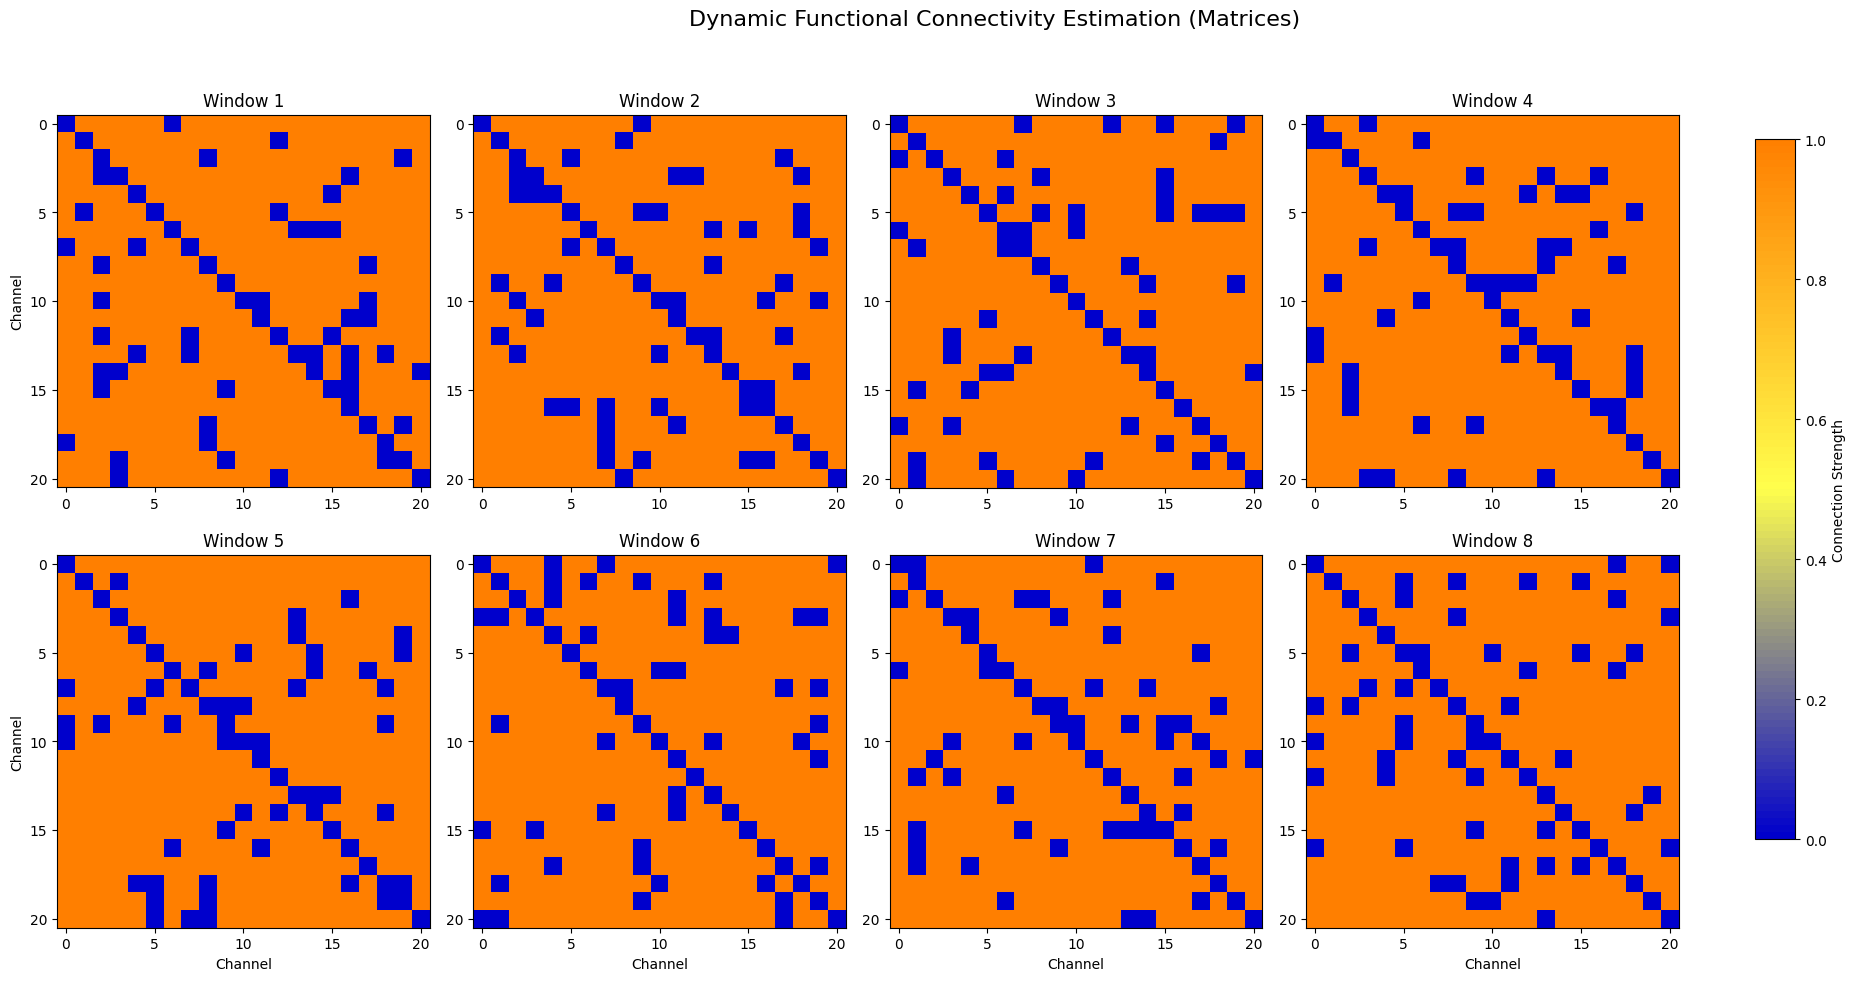

In [10]:
# Step 7: Visualize connectivity matrices similar to Image 1
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Make sure we have the all_graphs variable
# If it's not available, try loading it from file
try:
    # This will check if all_graphs exists
    _ = all_graphs.shape
    print(f"Using existing all_graphs with shape {all_graphs.shape}")
except:
    try:
        # Try to load from file
        all_graphs = np.load("eeg_connectivity_graphs.npy")
        print(f"Loaded all_graphs from file with shape {all_graphs.shape}")
    except:
        print("Error: Could not find all_graphs. Please make sure you've run the previous code blocks.")
        # Create dummy data for demonstration
        N = 20  # Example number of channels
        all_graphs = np.random.rand(8, N, N)
        print(f"Created dummy data with shape {all_graphs.shape}")

# Create a custom colormap similar to the one in Image 1 (orange-yellow)
colors = [(0, 0, 0.8), (1, 1, 0.3), (1, 0.5, 0)]  # Blue, Yellow, Orange
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=100)

# Get number of channels
N = all_graphs[0].shape[0]

# Create a figure with subplots for multiple time windows
num_windows_to_show = min(8, len(all_graphs))
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Plot connectivity matrices for selected windows
for i in range(num_windows_to_show):
    ax = axes[i]

    # Get the graph for this window
    graph = all_graphs[i]

    # Plot the connectivity matrix
    im = ax.imshow(graph, cmap=cmap, vmin=0, vmax=1)

    # Add labels and title
    ax.set_title(f"Window {i+1}")
    if i >= 4:  # Only add x-axis labels for bottom row
        ax.set_xlabel("Channel")
    if i % 4 == 0:  # Only add y-axis labels for leftmost column
        ax.set_ylabel("Channel")

    # Add ticks
    ax.set_xticks(np.arange(0, N, 5))
    ax.set_yticks(np.arange(0, N, 5))

# Add a colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("Connection Strength")

# Add a main title
plt.suptitle("Dynamic Functional Connectivity Estimation (Matrices)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

# Save the figure (you can comment this out if it's causing issues)
plt.savefig("dynamic_connectivity_matrices.png", dpi=300, bbox_inches='tight')

# Display the plot - this is important for Colab
plt.show()

In [11]:
# Step 8: Visualize connectivity graphs similar to Image 2
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Create a custom colormap for the bar charts (purple to yellow)
colors_bar = [(0.5, 0, 0.5), (0.8, 0, 0.8), (1, 0.5, 0), (1, 1, 0.3)]  # Purple to Yellow
cmap_bar = LinearSegmentedColormap.from_list('custom_bar_cmap', colors_bar, N=100)

# Create a figure
fig = plt.figure(figsize=(20, 10))

# Position for network graphs
graph_pos = fig.add_gridspec(1, 1, left=0.05, right=0.6, bottom=0.1, top=0.9)
graph_ax = fig.add_subplot(graph_pos[0, 0])

# Position for bar charts
num_windows_to_show = min(8, len(all_graphs))
bar_pos = fig.add_gridspec(1, num_windows_to_show, left=0.68, right=0.95, bottom=0.1, top=0.9, wspace=0.4)
bar_axes = [fig.add_subplot(bar_pos[0, i]) for i in range(num_windows_to_show)]

# Create a fixed node layout for consistency across all graphs
fixed_layout = nx.circular_layout(nx.DiGraph(all_graphs[0]))

# Create a composite graph visualization
graph_ax.set_title("Dynamic Functional Connectivity Graphs", fontsize=14)
graph_ax.axis('off')

# Draw multiple semi-transparent graphs
for i, graph_matrix in enumerate(all_graphs[:num_windows_to_show]):
    G = nx.DiGraph(graph_matrix)

    # Calculate edge weights (connection strengths)
    edge_weights = [graph_matrix[u, v] for u, v in G.edges()]

    # Draw the graph with varying opacity based on window index
    alpha = 0.3 + 0.7 * (i / (num_windows_to_show - 1)) if num_windows_to_show > 1 else 1.0
    nx.draw_networkx_nodes(G, fixed_layout, node_color='blue', node_size=100, alpha=alpha, ax=graph_ax)
    nx.draw_networkx_edges(G, fixed_layout, width=edge_weights, edge_color='gray',
                          alpha=alpha, arrows=True, arrowsize=10, ax=graph_ax)

# Create bar charts for each window
for i, ax in enumerate(bar_axes):
    if i < len(all_graphs):
        # Calculate node strengths (sum of incoming and outgoing connections)
        graph = all_graphs[i]
        in_strength = np.sum(graph, axis=0)
        out_strength = np.sum(graph, axis=1)
        total_strength = in_strength + out_strength

        # Sort nodes by total strength
        sorted_indices = np.argsort(total_strength)[::-1]
        sorted_strength = total_strength[sorted_indices]

        # Show top 10 nodes
        top_n = min(10, len(sorted_indices))

        # Create bar chart
        bars = ax.bar(range(top_n), sorted_strength[:top_n],
                     color=[cmap_bar(x/max(sorted_strength[:top_n])) for x in sorted_strength[:top_n]])

        # Add labels
        ax.set_title(f"Window {i+1}")
        ax.set_xlabel("Channel")
        if i == 0:
            ax.set_ylabel("Connection Strength")

        # Set x-ticks to show node indices
        ax.set_xticks(range(top_n))
        ax.set_xticklabels([f"{sorted_indices[j]}" for j in range(top_n)], rotation=45)

        # Adjust y-axis limits for consistency
        ax.set_ylim(0, max(total_strength) * 1.1)

plt.suptitle("Dynamic Functional Connectivity Analysis", fontsize=16)
plt.savefig("dynamic_connectivity_graphs.png", dpi=300, bbox_inches='tight')
plt.close()
plt.show()

In [12]:
# Step 9: Create a 3D visualization of connectivity changes over time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

# Create a custom colormap
colors = [(0, 0, 0.8), (1, 1, 0.3), (1, 0.5, 0)]  # Blue, Yellow, Orange
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=100)

# Create a figure
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create x, y coordinates for each node
num_nodes = all_graphs[0].shape[0]
x = np.cos(np.linspace(0, 2*np.pi, num_nodes, endpoint=False))
y = np.sin(np.linspace(0, 2*np.pi, num_nodes, endpoint=False))

# Plot connections for each time window
for t, graph in enumerate(all_graphs):
    # Plot nodes
    ax.scatter(x, y, t, c='blue', s=50, alpha=0.7)

    # Plot edges
    for i in range(num_nodes):
        for j in range(num_nodes):
            if graph[i, j] > 0.1:  # Only plot edges with strength > 0.1
                ax.plot([x[i], x[j]], [y[i], y[j]], [t, t],
                       c=cmap(graph[i, j]), alpha=0.5, linewidth=graph[i, j]*2)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time Window')
ax.set_title('Dynamic Functional Connectivity Over Time')

# Remove axis ticks for cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Set view angle
ax.view_init(elev=30, azim=45)

# Save the figure
plt.tight_layout()
plt.savefig("3d_connectivity_visualization.png", dpi=300, bbox_inches='tight')
plt.close()

In [13]:
# Step 10: Calculate and visualize connectivity metrics over time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Calculate various graph metrics for each time window
num_windows = len(all_graphs)
metrics = {
    'density': np.zeros(num_windows),
    'avg_clustering': np.zeros(num_windows),
    'global_efficiency': np.zeros(num_windows),
    'modularity': np.zeros(num_windows),
    'assortativity': np.zeros(num_windows)
}

for i, graph_matrix in enumerate(all_graphs):
    # Convert to NetworkX graph
    G = nx.from_numpy_array(graph_matrix, create_using=nx.DiGraph())

    # Calculate metrics
    metrics['density'][i] = nx.density(G)

    # For undirected metrics, create an undirected copy
    G_undir = G.to_undirected()

    # Calculate clustering coefficient (ignoring exceptions for disconnected graphs)
    try:
        metrics['avg_clustering'][i] = nx.average_clustering(G_undir)
    except:
        metrics['avg_clustering'][i] = 0

    # Calculate global efficiency (ignoring exceptions)
    try:
        metrics['global_efficiency'][i] = nx.global_efficiency(G_undir)
    except:
        metrics['global_efficiency'][i] = 0

    # Calculate modularity (using Louvain method)
    try:
        communities = nx.community.louvain_communities(G_undir)
        # Create a dictionary mapping node to community
        community_dict = {}
        for ci, community in enumerate(communities):
            for node in community:
                community_dict[node] = ci
        metrics['modularity'][i] = nx.community.modularity(G_undir, communities)
    except:
        metrics['modularity'][i] = 0

    # Calculate assortativity (correlation of degree between connected nodes)
    try:
        metrics['assortativity'][i] = nx.degree_assortativity_coefficient(G_undir)
    except:
        metrics['assortativity'][i] = 0

# Plot metrics over time
plt.figure(figsize=(15, 10))
time_axis = np.arange(num_windows)

for i, (metric_name, metric_values) in enumerate(metrics.items()):
    plt.subplot(2, 3, i+1)
    plt.plot(time_axis, metric_values, 'o-', linewidth=2)
    plt.title(f"{metric_name.replace('_', ' ').title()}")
    plt.xlabel("Time Window")

plt.tight_layout()
plt.suptitle("Dynamic Connectivity Metrics Over Time", fontsize=16, y=1.02)
plt.savefig("connectivity_metrics_over_time.png", dpi=300, bbox_inches='tight')
plt.close()

/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


In [14]:
# Step 11: Save all results and compress them
import numpy as np
import pickle
import os
import zipfile
import datetime

# Create a results directory
results_dir = "eeg_connectivity_results"
os.makedirs(results_dir, exist_ok=True)

# Save numpy arrays
np.save(os.path.join(results_dir, "connectivity_graphs.npy"), all_graphs)

# Save metrics
metrics_file = os.path.join(results_dir, "connectivity_metrics.pkl")
with open(metrics_file, 'wb') as f:
    pickle.dump(metrics, f)

# Save metadata
metadata = {
    'dataset_path': data_path,
    'file_used': edf_files[0] if edf_files else None,
    'num_channels': N,
    'window_size': window_size,
    'overlap': overlap,
    'num_iterations': num_iterations,
    'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

metadata_file = os.path.join(results_dir, "metadata.pkl")
with open(metadata_file, 'wb') as f:
    pickle.dump(metadata, f)

# Copy all PNG files to the results directory
for file in os.listdir():
    if file.endswith('.png'):
        os.rename(file, os.path.join(results_dir, file))

# Compress the results directory
with zipfile.ZipFile("eeg_connectivity_results.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            zipf.write(os.path.join(root, file),
                      os.path.relpath(os.path.join(root, file),
                                      os.path.join(results_dir, '..')))

print("Results saved and compressed to eeg_connectivity_results.zip")

Results saved and compressed to eeg_connectivity_results.zip
